# TP3 RN2 - Bautista Schneeberger

En este TP uso como dataset la Constitución de la República Soberana y Democrática Argentina.

Comparo la estrategia Many to One con Many to Many (sugerida por Carlos en clase). Ante *ceteris paribus*, Many to One outperformó a Many to Many. Hipótesis: Many to One amplia la cantidad de datos de train, entonces *es como si* se hiciese un data augmentation.





In [53]:
import zipfile
from matplotlib import pyplot as plt
from collections import Counter
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [54]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.es.300.vec.gz

--2023-11-02 07:58:23--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.es.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.35.7.50, 13.35.7.82, 13.35.7.128, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.35.7.50|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1285580896 (1.2G) [binary/octet-stream]
Saving to: ‘cc.es.300.vec.gz.1’

cc.es.300.vec.gz.1  100%[===================>]   1.20G  59.3MB/s    in 15s     

2023-11-02 07:58:38 (81.0 MB/s) - ‘cc.es.300.vec.gz.1’ saved [1285580896/1285580896]



Embeddings en español

In [72]:
import gzip
import os

downloaded_file = 'cc.es.300.vec.gz'
unzipped_file = 'cc.es.300.vec'

if not os.path.isfile(unzipped_file):
    with gzip.open(downloaded_file, 'rb') as f_in:
        with open(unzipped_file, 'wb') as f_out:
            for line in f_in:
                f_out.write(line)

In [73]:
import re
alphabets= "([A-Za-z])"
prefixes = "(Mr|St|Mrs|Ms|Dr|no|No)[.]"
suffixes = "(Inc|Ltd|Jr|Sr|Co)"
starters = "(Mr|Mrs|Ms|Dr|Prof|Capt|Cpt|Lt|He\s|She\s|It\s|They\s|Their\s|Our\s|We\s|But\s|However\s|That\s|This\s|Wherever)"
acronyms = "([A-Z][.][A-Z][.](?:[A-Z][.])?)"
websites = "[.](com|net|org|io|gov|edu|me)"
digits = "([0-9])"
multiple_dots = r'\.{2,}'

def split_into_sentences(text: str) -> list[str]:
    """
    Split the text into sentences.

    If the text contains substrings "<prd>" or "<stop>", they would lead
    to incorrect splitting because they are used as markers for splitting.

    :param text: text to be split into sentences
    :type text: str

    :return: list of sentences
    :rtype: list[str]
    """
    text = " " + text + "  "
    text = text.replace("\n"," ")
    text = re.sub(prefixes,"\\1<prd>",text)
    text = re.sub(websites,"<prd>\\1",text)
    text = re.sub(digits + "[.]" + digits,"\\1<prd>\\2",text)
    text = re.sub(multiple_dots, lambda match: "<prd>" * len(match.group(0)) + "<stop>", text)
    if "Ph.D" in text: text = text.replace("Ph.D.","Ph<prd>D<prd>")
    text = re.sub("\s" + alphabets + "[.] "," \\1<prd> ",text)
    text = re.sub(acronyms+" "+starters,"\\1<stop> \\2",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>\\3<prd>",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>",text)
    text = re.sub(" "+suffixes+"[.] "+starters," \\1<stop> \\2",text)
    text = re.sub(" "+suffixes+"[.]"," \\1<prd>",text)
    text = re.sub(" " + alphabets + "[.]"," \\1<prd>",text)
    if "”" in text: text = text.replace(".”","”.")
    if "\"" in text: text = text.replace(".\"","\".")
    if "!" in text: text = text.replace("!\"","\"!")
    if "?" in text: text = text.replace("?\"","\"?")
    text = text.replace(".",".<stop>")
    text = text.replace("?","?<stop>")
    text = text.replace("!","!<stop>")
    text = text.replace("<prd>",".")
    sentences = text.split("<stop>")
    sentences = ['<SOS> ' + s.strip() + ' <EOS>' for s in sentences]
    if sentences and not sentences[-1]: sentences = sentences[:-1]
    return sentences

In [74]:
with open("output.txt", 'r', encoding='utf-8') as file:
    book = file.read()

In [75]:
book = split_into_sentences(book)

In [76]:
book[1200]

'<SOS> Deberá ser  presentada al Secretario General de la Organización, quien transmitirá copias de  la misma a los otros Estados miembros de la Organización y al Secretario de la  Corte. <EOS>'

In [77]:
maxTokens = 5000
token = Tokenizer(num_words=maxTokens,
                  filters='!"“”#$%&()*+,.-/:;=?@[\\]^_`{|}~\t\n\ufeff\u2002', lower=True,
                  split=' ', char_level=False, oov_token=None)
token.fit_on_texts(book)

In [78]:
sequences = token.texts_to_sequences(book)

Text(0.5, 0, 'Cantidad de palabras en la oración')

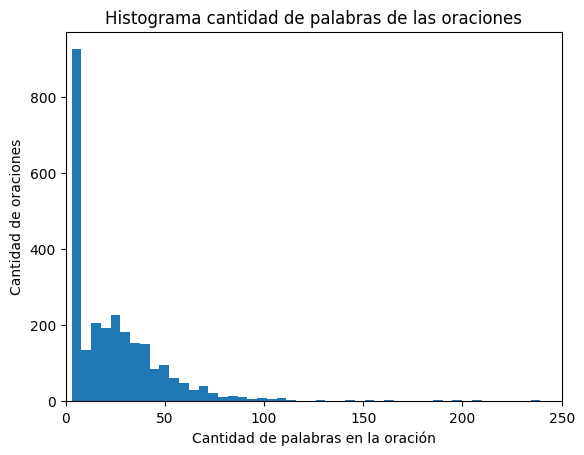

In [79]:
lens = [len(seq) for seq in sequences]
plt.hist(lens, bins = len(lens)//16);
plt.xlim(0, 250)
plt.title('Histograma cantidad de palabras de las oraciones')
plt.ylabel('Cantidad de oraciones')
plt.xlabel('Cantidad de palabras en la oración')

Me quedo con las oraciones menores a 50 palabras

In [80]:
sequences = [sublist for sublist in sequences if len(sublist) <= 50]

In [81]:
len(sequences)

2322

# Many to One. LSTM + MLP

In [84]:
def create_dataset(sequence):
    inputs = []
    outputs = []
    for i, sent in enumerate(sequence):
        for j in range(1, len(sent)-1):
          inputs.append(sent[:j])
          outputs.append([sent[j]])

    return inputs, outputs

In [85]:
X, y = create_dataset(sequences)
x_train = pad_sequences(X, maxlen=maxLen)
y_train = np.array(y)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.3)

In [87]:
reverse_dictionary = token.index_word
dictionary = dict([(value, key) for (key, value) in reverse_dictionary.items()])
num_words=len(dictionary)+1

In [88]:
import codecs
import IPython.display as ipd
from IPython.display import Audio, update_display
from ipywidgets import IntProgress

EMB = "wiki-news-300d-1M.vec"
EMB = "cc.es.300.vec"
N = 1000000

#load embeddings
print('loading word embeddings...')
embeddings_index = {}
f = codecs.open(f'./{EMB}', encoding='utf-8')
bar = IntProgress(min=0, max=N)
ipd.display(bar)

i = 0
for n, line in enumerate(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
    if n//(N//100) > i:
          bar.value = n
          i += 1
f.close()
print('found %s word vectors' % len(embeddings_index))

loading word embeddings...


IntProgress(value=0, max=1000000)

found 2000000 word vectors


In [102]:
embed_dim=300
embedding_matrix=np.zeros([num_words, embed_dim])
for word, idx in dictionary.items():
  if word in embeddings_index:
    embedding_matrix[idx,:]=embeddings_index[word]

In [103]:
from tensorflow.keras.layers import Masking, Embedding, Bidirectional, LSTM, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout, Dense, Input, Concatenate, Dot, RepeatVector, TimeDistributed, Multiply, Lambda, Flatten, Activation, Reshape, BatchNormalization
import tensorflow.keras.backend as K
from tensorflow.keras.activations import softmax
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import optimizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

nb_words = len(embedding_matrix) #Vocabulary size
embed_dim = len(embedding_matrix[0]) #Vectorization dim
value_dim = 100
maxLen = len(x_train[0])

In [118]:
input_layer = Input(shape=(maxLen,)) #Cantidad maxima de la frase de entrada, estos son los timesteps para este caso
embedding_layer = Embedding(nb_words, embed_dim, weights=[embedding_matrix], input_length=maxLen, trainable=True)(input_layer)
lstm = LSTM(value_dim, return_sequences=False, activation="tanh")(embedding_layer)
drop = Dropout(0.4)(lstm)
dense_hidden = Dense(32, activation='relu')(drop)
dense2 = Dense(nb_words, activation='softmax')(dense_hidden)
model = Model(inputs=input_layer, outputs=dense2)

In [119]:
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding_6 (Embedding)     (None, 50, 300)           1765800   
                                                                 
 lstm_6 (LSTM)               (None, 100)               160400    
                                                                 
 dropout_6 (Dropout)         (None, 100)               0         
                                                                 
 dense_10 (Dense)            (None, 32)                3232      
                                                                 
 dense_11 (Dense)            (None, 5886)              194238    
                                                                 
Total params: 2123670 (8.10 MB)
Trainable params: 2123670 (

In [144]:
model.save_weights('model_weights.h5')

In [120]:
callbackROP = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5)
callbackES = EarlyStopping(monitor='val_loss', patience=10)

In [121]:
from keras.optimizers import Adam

model.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(learning_rate = 0.01))

In [122]:
model.fit(x=x_train, y=y_train, validation_data=(x_test, y_test), batch_size=512, epochs=50, callbacks=[callbackROP, callbackES])

Epoch 1/50
51/51 [==============================] - 55s 1s/step - loss: 6.5900 - val_loss: 6.1246 - lr: 0.0100
Epoch 2/50
51/51 [==============================] - 55s 1s/step - loss: 5.7817 - val_loss: 5.6881 - lr: 0.0100
Epoch 3/50
51/51 [==============================] - 46s 891ms/step - loss: 5.2484 - val_loss: 5.4172 - lr: 0.0100
Epoch 4/50
51/51 [==============================] - 44s 863ms/step - loss: 4.8434 - val_loss: 5.2778 - lr: 0.0100
Epoch 5/50
51/51 [==============================] - 43s 851ms/step - loss: 4.5577 - val_loss: 5.2110 - lr: 0.0100
Epoch 6/50
51/51 [==============================] - 43s 845ms/step - loss: 4.3255 - val_loss: 5.1890 - lr: 0.0100
Epoch 7/50
51/51 [==============================] - 43s 853ms/step - loss: 4.1489 - val_loss: 5.2192 - lr: 0.0100
Epoch 8/50
51/51 [==============================] - 42s 830ms/step - loss: 4.0090 - val_loss: 5.2154 - lr: 0.0100
Epoch 9/50
51/51 [==============================] - 43s 842ms/step - loss: 3.8993 - val_loss: 

# Greedy search + ArgMax

In [123]:
def greedy_search(question, outputLen, model, many2many = False):

  out = 0
  response = []
  reply = question
  finished = False

  while out != token.texts_to_sequences(["<eos>"])[0][0] and len(response) < outputLen:
      out = pad_sequences(reply, maxlen=maxLen)
      out = model.predict(out, verbose=0)
      if many2many == True:
        out = out[..., -1, :]
      out = int(np.argmax(out))
      reply[0] += [out]
      response.append(out)

  return response

In [ ]:
question = token.texts_to_sequences(["<sos> estados"])

In [124]:
def from_seq_to_text(seq):
    return token.sequences_to_texts([seq])

In [126]:
response = greedy_search(question, outputLen=25, model = model)
rta = from_seq_to_text(response)
rta

['partes en el presente protocolo está sujeta a la nación y a la nación argentina reunidos en el presente pacto entrará en el presente pacto']

# Greedy search + T

In [127]:
def changeTemp(a, temperature=1.0, epsilon=1e-8):
    a = np.log(a) / temperature
    sampled_temp = np.exp(a+epsilon)/(np.exp(a+epsilon).sum())
    sampled_temp = sampled_temp/sampled_temp.sum()
    return sampled_temp

In [128]:
def greedy_search_withT(question, model, max_len=10, T=1.0, many2many = False):

  out = 0
  response = []
  reply = question
  finished = False
  eof = token.texts_to_sequences(["<eos>"])[0][0]

  while out != eof and len(response) < max_len:

      out = pad_sequences(reply, maxlen=maxLen)
      out = model.predict(out, verbose=0)
      if many2many == True:
        out = out[..., -1, :]
      temp = changeTemp(out[0], temperature=T)
      out = np.random.choice(range(len(temp)), p=temp)
      reply[0] += [out]
      if out in response:
        finished = True
      else:
        response.append(out)

  return response

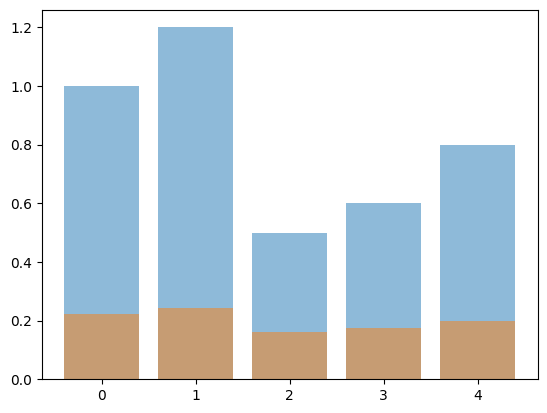

In [129]:
arr1 = [1, 1.2, 0.5, 0.6, 0.8]
plt.figure()
plt.bar(range(len(arr1)), arr1, alpha=0.5)
arr2 = changeTemp(arr1, temperature=2.1)
plt.bar(range(len(arr2)), arr2, alpha=0.5)
plt.show()


In [130]:
question = token.texts_to_sequences(["<sos> estados"])

In [133]:
def from_seq_to_text(seq):
    return token.sequences_to_texts([seq])

response = greedy_search_withT(question, model = model,max_len=25, T=0.5)
rta = from_seq_to_text(response)
rta

['reunidos en cuenta sus riquezas y recomendaciones que adoptar la seguridad social sean perjudiciales para información pertinente h pereyra han aceptado de las naciones unidas']

# Stochastic beam search + T

In [134]:
def stoch_beam_search(kBeams, maxOutputLen, candidatesAndProb, model, T=1.0, many2many = False):

  candidates = candidatesAndProb[0]
  probabilities = candidatesAndProb[1]

  if maxOutputLen < 1:
    return candidates, probabilities
  else:

    possibleCand = [0]*kBeams
    possibleProb = [0]*kBeams

    #Calculamos los candidatos para cada rama, kBeams candidatos maximos
    for curr in candidates:
      out = pad_sequences([curr], maxlen=maxLen)
      out = model.predict(out, verbose=0) #Probabilidades
      if many2many == True:
        out = out[..., -1, :]
      temp = changeTemp(out[0], temperature=T)
      newCandidates = np.argsort(temp)[::-1][:kBeams] #Agarramos los indices de los k-elementos con mas prob
      newCandidates = [[num] for num in newCandidates] #Convertimos los numeros en listas de numeros por compatibilidad con pad_sequences
      newCandProba = [temp[i] for i in newCandidates] #Agarramos su probabilidad

      #Elegimos los kBeams caminos con mas probabilidad
      for i, prob in enumerate(newCandProba): #Agarramos la probabilidad de cada candidato
        for j in range(len(possibleProb)): #Para cada probabilidad maxima guardada
          if possibleProb[j] < prob and newCandProba[i] not in possibleCand:
            possibleProb[j] = prob
            possibleCand[j] = newCandProba[i]

    #print(possibleCand)
    #print(possibleProb)

    concatenated = np.concatenate((candidates, newCandidates), axis=1)
    probabilities = np.multiply(probabilities, newCandProba)

    #print(concatenated)
    #print(probabilities)

    return stoch_beam_search(kBeams, maxOutputLen-1, (concatenated, probabilities), model = model, T = T, many2many = many2many)


In [135]:
question = token.texts_to_sequences(["<sos> estados"])

In [138]:
maxOutputLen = 20
kBeams = 5
candidates = (question*kBeams, 1*kBeams)

outSeq, outProb = stoch_beam_search(kBeams, maxOutputLen, candidates, T=1.1, model = model)
result = token.sequences_to_texts(outSeq)

for i, sent in enumerate(result):
  print(f"prob: {outProb[i][0]:.10f} - Rta: {sent}")


prob: 0.0000000000 - Rta: <sos> estados partes sin la honra reglamento las la estado competente y comprometen elegidos por comité de la momento y la propio
prob: 0.0000000000 - Rta: <sos> estados americanos inmediatamente los personalidad país su los período independiente en depositarán como la congreso y el estado del los familia
prob: 0.0000000000 - Rta: <sos> estados mencionados por el familia ni la partir plazo de o hace exigidas a secretario del que otro a las honra
prob: 0.0000000000 - Rta: <sos> estados miembros de asegurar caso presidente el una tercio judicial de convoque correctiva las estado o los caso que sus caso
prob: 0.0000000000 - Rta: <sos> estados federales para su propio efecto a un tribunal nacional se considerarán posible el presidente en cualquier país de su cargo


# Many to many

In [145]:
y = []
for seq in sequences: # Shifteo la oración para la predicción a un lag
  seq = seq[0:-1]
  seq.insert(0, 0)
  y.append(seq)

x_train = pad_sequences(sequences, maxlen=maxLen)
y_train = pad_sequences(y, maxlen=maxLen)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.3)


In [146]:
nb_words = len(embedding_matrix) #Vocabulary size
embed_dim = len(embedding_matrix[0]) #Vectorization dim
value_dim = 100
maxLen = len(x_train[0])

In [147]:
input_layer = Input(shape=(maxLen,)) #Cantidad maxima de la frase de entrada, estos son los timesteps para este caso
embedding_layer = Embedding(nb_words, embed_dim, weights=[embedding_matrix], input_length=maxLen, trainable=True)(input_layer)
mask = Masking(mask_value=0.0, input_shape=(embed_dim, value_dim))(embedding_layer)
lstm = LSTM(value_dim, return_sequences=True, activation="tanh")(mask)
drop = Dropout(0.4)(lstm)
hidden_dense = Dense(32, activation='relu')(drop)
dense2 = Dense(nb_words, activation='softmax')(hidden_dense)
model2 = Model(inputs=input_layer, outputs=dense2)

In [148]:
model2.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding_8 (Embedding)     (None, 50, 300)           1765800   
                                                                 
 masking_3 (Masking)         (None, 50, 300)           0         
                                                                 
 lstm_8 (LSTM)               (None, 50, 100)           160400    
                                                                 
 dropout_8 (Dropout)         (None, 50, 100)           0         
                                                                 
 dense_14 (Dense)            (None, 50, 32)            3232      
                                                                 
 dense_15 (Dense)            (None, 50, 5886)          1942

In [149]:
model2.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(learning_rate=0.01))

In [150]:
model2.fit(x=x_train, y=y_train, validation_data=(x_test, y_test), batch_size=512, epochs=50, callbacks=[callbackROP, callbackES])

Epoch 1/50
4/4 [==============================] - 34s 7s/step - loss: 8.5451 - val_loss: 7.1582 - lr: 0.0100
Epoch 2/50
4/4 [==============================] - 15s 4s/step - loss: 6.7316 - val_loss: 6.5289 - lr: 0.0100
Epoch 3/50
4/4 [==============================] - 19s 5s/step - loss: 6.1959 - val_loss: 6.3666 - lr: 0.0100
Epoch 4/50
4/4 [==============================] - 17s 4s/step - loss: 6.0746 - val_loss: 6.1997 - lr: 0.0100
Epoch 5/50
4/4 [==============================] - 15s 4s/step - loss: 5.8940 - val_loss: 6.1556 - lr: 0.0100
Epoch 6/50
4/4 [==============================] - 14s 4s/step - loss: 5.8088 - val_loss: 6.0151 - lr: 0.0100
Epoch 7/50
4/4 [==============================] - 14s 4s/step - loss: 5.6716 - val_loss: 5.9003 - lr: 0.0100
Epoch 8/50
4/4 [==============================] - 14s 4s/step - loss: 5.5669 - val_loss: 5.7626 - lr: 0.0100
Epoch 9/50
4/4 [==============================] - 14s 4s/step - loss: 5.4518 - val_loss: 5.6814 - lr: 0.0100
Epoch 10/50
4/4 [==

In [151]:
token.sequences_to_texts([x_test[40]])

['<sos> 2 <eos>']

In [157]:
[x_test[15]]

[array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3, 173,
        204,  98, 462,  84, 267,   2, 286,   8,  89, 204,   4], dtype=int32)]

In [159]:
question = token.texts_to_sequences(["<sos> Estados"])

In [160]:
response = greedy_search(question, outputLen=20, model = model2, many2many = True)
rta = from_seq_to_text(response)
rta

['<sos> <sos> <sos> <sos> <sos> <sos> <sos> <sos> <sos> <sos> <sos> <sos> <sos> <sos> <sos> <sos> <sos> <sos> <sos> <sos>']

In [155]:
response = greedy_search_withT(question, model2, max_len=20, T=100, many2many = True)
rta = from_seq_to_text(response)
rta

['surgida orientación entrará incitación sentencia sesión reciba comprende vías mismos becas política esente conservará realizados efectivo']

In [156]:
maxOutputLen = 5
kBeams = 5
candidates = (question*kBeams, 1*kBeams)

outSeq, outProb = stoch_beam_search(kBeams, maxOutputLen, candidates, model = model2, T=1, many2many = True)
result = token.sequences_to_texts(outSeq)

for i, sent in enumerate(result):
  print(f"prob: {outProb[i][0]:.10f} - Rta: {sent}")


prob: 0.0000012796 - Rta: <sos> estados <sos> <sos> <sos> <sos> <sos> <sos> <sos> <sos> <sos> <sos> <sos> <sos> <sos> <sos> <sos> <sos> <sos> <sos> <sos> <sos> surgida orientación entrará incitación sentencia sesión reciba comprende vías mismos becas política esente conservará realizados efectivo posible sido integrada interno pectiva
prob: 0.0000004257 - Rta: <sos> estados <sos> <sos> <sos> <sos> <sos> <sos> <sos> <sos> <sos> <sos> <sos> <sos> <sos> <sos> <sos> <sos> <sos> <sos> <sos> <sos> surgida orientación entrará incitación sentencia sesión reciba comprende vías mismos becas política esente conservará realizados efectivo obligados está transmitidos literarias interno
prob: 0.0000000884 - Rta: <sos> estados <sos> <sos> <sos> <sos> <sos> <sos> <sos> <sos> <sos> <sos> <sos> <sos> <sos> <sos> <sos> <sos> <sos> <sos> <sos> <sos> surgida orientación entrará incitación sentencia sesión reciba comprende vías mismos becas política esente conservará realizados efectivo ación unidas obligad

In [179]:
model2.save_weights('model2_weights.h5')

# Perplejidad
*Def*:
$$
\text{Perplexity} = \Pi_{t=1}^T (\frac{1}{P(x^{(t+1)}|x^{(t)},...,x^{(1)})})^{1/T}
$$

In [175]:
def perplexity(model, init_seq, many2many = False):
  seq = init_seq
  score = 1
  for i in range(2, len(seq[0])):
    out = pad_sequences([seq[0][:i]], maxlen=maxLen)
    out = model.predict(out, verbose=0)
    if many2many == True:
      out = np.array([out[0,-1, :]])
    score *= (1/out[0][seq[0][i]])**(1/len(seq[0]))
  return score

Perplexity con many to one

In [173]:
question = token.texts_to_sequences(["<sos> El presidente debe cumplir las normas"])
print(question)
score = perplexity(model, question, many2many=False)
score

[[3, 9, 121, 163, 1382, 11, 345]]


40.467258117400426

Perplexity con many to many

In [176]:
score = perplexity(model2, question, many2many=True)
score

171522098.9835128

Es dudoso el valor de la perplejidad para el modelo many to many. Aunque al menos tiene sentido que de peor que many to one, dado que lo resultados con texto probados asi lo muestran.

#SimpleRNN

In [184]:
from tensorflow.keras.layers import SimpleRNN
model3 = tf.keras.Sequential()
model3.add(Input(shape=(maxLen,)))
model3.add(Embedding(nb_words, embed_dim, weights=[embedding_matrix], input_length=maxLen, trainable=True))
model3.add(SimpleRNN(value_dim, return_sequences=False, activation="tanh"))
model3.add(Dropout(0.4))
model3.add(Dense(32, activation='relu'))
model3.add(Dense(nb_words, activation='softmax'))

In [185]:
model3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 50, 300)           1765800   
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 100)               40100     
                                                                 
 dropout_10 (Dropout)        (None, 100)               0         
                                                                 
 dense_18 (Dense)            (None, 32)                3232      
                                                                 
 dense_19 (Dense)            (None, 5886)              194238    
                                                                 
Total params: 2003370 (7.64 MB)
Trainable params: 2003370 (7.64 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [186]:
model3.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(learning_rate=0.01))

Uso many to one

In [187]:
X, y = create_dataset(sequences)
x_train = pad_sequences(X, maxlen=maxLen)
y_train = np.array(y)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.3)

In [188]:
model3.fit(x=x_train, y=y_train, validation_data=(x_test, y_test), batch_size=512, epochs=50, callbacks=[callbackROP, callbackES])

Epoch 1/50
51/51 [==============================] - 20s 337ms/step - loss: 6.5865 - val_loss: 6.1383 - lr: 0.0100
Epoch 2/50
51/51 [==============================] - 17s 332ms/step - loss: 5.9716 - val_loss: 5.9297 - lr: 0.0100
Epoch 3/50
51/51 [==============================] - 20s 384ms/step - loss: 5.6004 - val_loss: 5.6059 - lr: 0.0100
Epoch 4/50
51/51 [==============================] - 17s 336ms/step - loss: 5.1852 - val_loss: 5.4325 - lr: 0.0100
Epoch 5/50
51/51 [==============================] - 18s 348ms/step - loss: 4.9233 - val_loss: 5.3507 - lr: 0.0100
Epoch 6/50
51/51 [==============================] - 17s 333ms/step - loss: 4.7203 - val_loss: 5.2861 - lr: 0.0100
Epoch 7/50
51/51 [==============================] - 17s 330ms/step - loss: 4.5560 - val_loss: 5.2579 - lr: 0.0100
Epoch 8/50
51/51 [==============================] - 18s 352ms/step - loss: 4.4089 - val_loss: 5.2691 - lr: 0.0100
Epoch 9/50
51/51 [==============================] - 17s 331ms/step - loss: 4.2738 - val_

In [190]:
question = token.texts_to_sequences(["<sos> El presidente debe cumplir las normas"])
print(question)
score = perplexity(model3, question, many2many=False)
score

[[3, 9, 121, 163, 1382, 11, 345]]


104.84285198186203

## Dio una perplejidad peor ante ceteris paribus, por lo tanto LSTM es superior. *qed*